<img src="https://raw.githubusercontent.com/oscarandres16/crescendo/master/banner.jpg" align="center">




In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [180]:
!pip install geopandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/Proyecto-IA
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Proyecto-IA
/content/drive/My Drive/Proyecto-IA


#Importacion de datos

In [161]:
import pandas as pd
datos = pd.read_csv("sismosColombia.csv")
print (datos.shape)
datos.head(-1)

(12243, 19)


,FECHA,HORA UTC,TIPO_SISMO,LATITUD,LONGITUD,PROFUNDIDAD,MAGNITUD ML,MAGNITUD MW,AGENCIA,NUMERO_DE_ESTACIONES,NOMBRE_SFILE,NOMBRE_FORMA_ONDA,DEPARTMENTO,MUNICIPIO,RMS,ERROR_LATITUD,ERROR_LONGITUD,ERROR_PROFUNDIDAD,GAP
0,01/01/2015 12:00:00 AM,00:15:46,L,3.970,-76.921,52.0,1.4,NaN,RSN,4,01-0015-46L.S201501,2015-01-01-0007-43M.COL___277,VALLE DEL CAUCA,BUENAVENTURA,0.7,8.0,6.0,16.0,118
1,01/01/2015 12:00:00 AM,01:17:46,L,4.661,-76.165,122.0,2.6,NaN,RSN,23,01-0117-46L.S201501,2015-01-01-0107-44M.COL___277,VALLE DEL CAUCA,ARGELIA,0.8,3.1,3.6,6.6,50
2,01/01/2015 12:00:00 AM,01:33:01,L,6.826,-73.145,142.5,2.1,NaN,RSN,20,01-0133-01L.S201501,2015-01-01-0127-43M.COL___277,SANTANDER,LOS SANTOS,0.6,3.5,5.0,6.9,119
3,01/01/2015 12:00:00 AM,02:50:01,L,7.873,-74.122,23.8,1.1,NaN,RSN,5,01-0250-01L.S201501,2015-01-01-0247-42M.COL___277,BOLIVAR,SANTA ROSA DEL SUR,0.3,1.9,5.5,5.4,169
4,01/01/2015 12:00:00 AM,03:38:19,L,7.433,-73.387,116.1,1.8,NaN,RSN,9,01-0338-19L.S201501,2015-01-01-0327-47M.COL___277,SANTANDER,SABANA DE TORRES,0.6,4.1,5.6,9.8,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12237,12/31/2015 12:00:00 AM,22:02:42,L,6.699,-73.200,151.3,1.4,NaN,RSN,5,31-2202-42L.S201512,2015-12-31-2157-48M.COL___328,SANTANDER,VILLANUEVA,0.3,7.5,8.4,5.8,222
12238,12/31/2015 12:00:00 AM,22:03:15,L,6.624,-73.375,66.3,1.1,NaN,RSN,5,31-2203-15L.S201512,2015-12-31-2157-48M.COL___328,SANTANDER,GALAN,0.3,4.4,4.7,8.1,134
12239,12/31/2015 12:00:00 AM,22:03:30,L,6.627,-73.255,116.0,1.3,NaN,RSN,5,31-2203-30L.S201512,2015-12-31-2157-48M.COL___328,SANTANDER,BARICHARA,0.4,6.8,7.1,8.7,160
12240,12/31/2015 12:00:00 AM,22:34:47,L,6.787,-73.137,146.4,1.7,NaN,RSN,7,31-2234-47L.S201512,2015-12-31-2227-48M.COL___328,SANTANDER,LOS SANTOS,0.3,3.0,4.3,5.5,201


In [174]:
#BORRANDO DATOS INNECESARIOS
datos = pd.read_csv("sismosColombia.csv")
datos['FECHA'] = pd.to_datetime(datos['FECHA'])
datos = datos.rename(columns={'HORA UTC':'HORA','MAGNITUD ML':'MAGNITUD_ML'})
del datos['MAGNITUD MW']
del datos['AGENCIA']
del datos['NUMERO_DE_ESTACIONES']
del datos['NOMBRE_SFILE']
del datos['NOMBRE_FORMA_ONDA']
del datos['DEPARTMENTO']
del datos['MUNICIPIO']
del datos['TIPO_SISMO']
datos.head()

,FECHA,HORA,LATITUD,LONGITUD,PROFUNDIDAD,MAGNITUD_ML,RMS,ERROR_LATITUD,ERROR_LONGITUD,ERROR_PROFUNDIDAD,GAP
0,2015-01-01,00:15:46,3.970,-76.921,52.0,1.4,0.7,8.0,6.0,16.0,118
1,2015-01-01,01:17:46,4.661,-76.165,122.0,2.6,0.8,3.1,3.6,6.6,50
2,2015-01-01,01:33:01,6.826,-73.145,142.5,2.1,0.6,3.5,5.0,6.9,119
3,2015-01-01,02:50:01,7.873,-74.122,23.8,1.1,0.3,1.9,5.5,5.4,169
4,2015-01-01,03:38:19,7.433,-73.387,116.1,1.8,0.6,4.1,5.6,9.8,93


**HACIENDO UN DICCIONARIO PARA LOS DEPARTAMENTOS Y MUNICIPIOS**

si esto resulta no serán eliminados del **dataset**

In [175]:
depar_munic=pd.read_csv('Departamentos_y_municipios_de_Colombia.csv')
del depar_munic['REGION']
depar_munic = depar_munic.rename(columns={'CÓDIGO DANE DEL DEPARTAMENTO':'COD_DEP','CÓDIGO DANE DEL MUNICIPIO':'COD_MUN'})
#depar_munic['DEPARTAMENTO'] = str(depar_munic['DEPARTAMENTO'])
#depar_munic['MUNICIPIO'] = str(depar_munic['MUNICIPIO'])
d = depar_munic['DEPARTAMENTO']
#depar_munic['DEPARTAMENTO'] = d[:,13:22]
print(depar_munic.dtypes)
#depar_munic['DEPARTAMENTO'].upper()
#depar_munic['MUNICIPIO'].upper()
depar_munic.head()

#datos['DEPARTAMENTO'] = depar_munic[]

COD_DEP          int64
DEPARTAMENTO    object
COD_MUN          int64
MUNICIPIO       object
dtype: object


,COD_DEP,DEPARTAMENTO,COD_MUN,MUNICIPIO
0,5,Antioquia,5001,Medellín
1,5,Antioquia,5002,Abejorral
2,5,Antioquia,5004,Abriaquí
3,5,Antioquia,5021,Alejandría
4,5,Antioquia,5030,Amagá


BUSCANDO NUESTRO X

In [176]:
datos_fecha = pd.to_datetime(datos['FECHA'])
data = [[x.day, x.month] for x in datos_fecha]
dataset_x = pd.DataFrame(np.array(data),columns=['DIA', 'MES'])
tiempos = datos['HORA']
for i in range(len(tiempos)):
  if(type(datos['HORA'].loc[i])==int):
    break
  else:
    tiempo = tiempos.loc[i]
    horas = int(tiempo[0:2])
    minutos = int(tiempo[3:5])
    segundos = int(tiempo[6:8])
    segundosTotales = horas*3600+minutos*60+segundos
    tiempos[i]  = segundosTotales
datos['HORA'] = tiempos.astype(float)
dataset_x['HORA'] = datos['HORA']

print(dataset_x)

       DIA  MES     HORA
0        1    1    946.0
1        1    1   4666.0
2        1    1   5581.0
3        1    1  10201.0
4        1    1  13099.0
...    ...  ...      ...
12238   31   12  79395.0
12239   31   12  79410.0
12240   31   12  81287.0
12241   31   12  81761.0
12242   31   12  86110.0

[12243 rows x 3 columns]


BUSCANDO NUESTRO Y

In [177]:
dataset_y = datos.iloc[:,2:10]
print(dataset_y)

       LATITUD  LONGITUD  ...  ERROR_LONGITUD  ERROR_PROFUNDIDAD
0        3.970   -76.921  ...             6.0               16.0
1        4.661   -76.165  ...             3.6                6.6
2        6.826   -73.145  ...             5.0                6.9
3        7.873   -74.122  ...             5.5                5.4
4        7.433   -73.387  ...             5.6                9.8
...        ...       ...  ...             ...                ...
12238    6.624   -73.375  ...             4.7                8.1
12239    6.627   -73.255  ...             7.1                8.7
12240    6.787   -73.137  ...             4.3                5.5
12241    6.801   -73.087  ...             6.5                6.3
12242    5.704   -74.260  ...             2.2                4.8

[12243 rows x 8 columns]


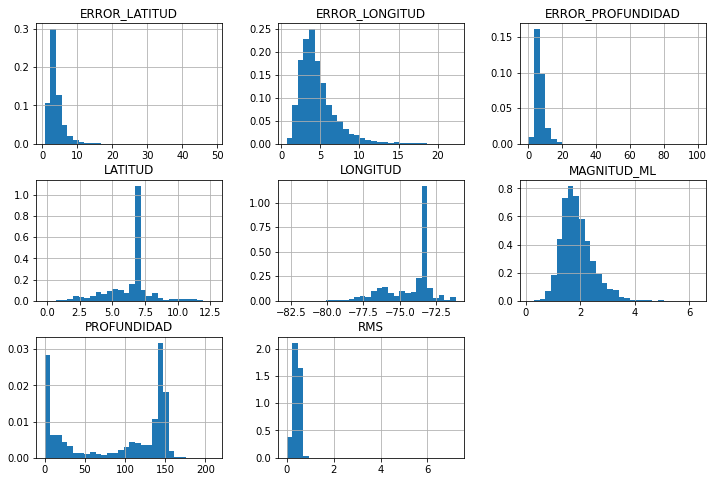

In [178]:
dataset_y.hist(bins=30,  density=True, figsize=(12,8));

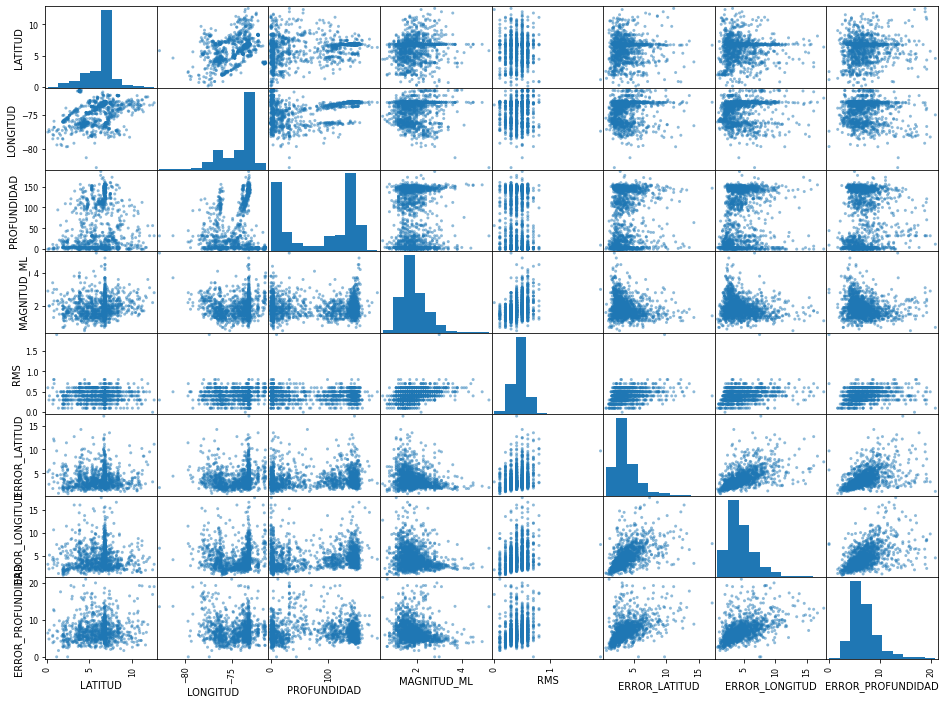

In [179]:
pd.plotting.scatter_matrix(dataset_y.sample(1500), figsize=(16,12));

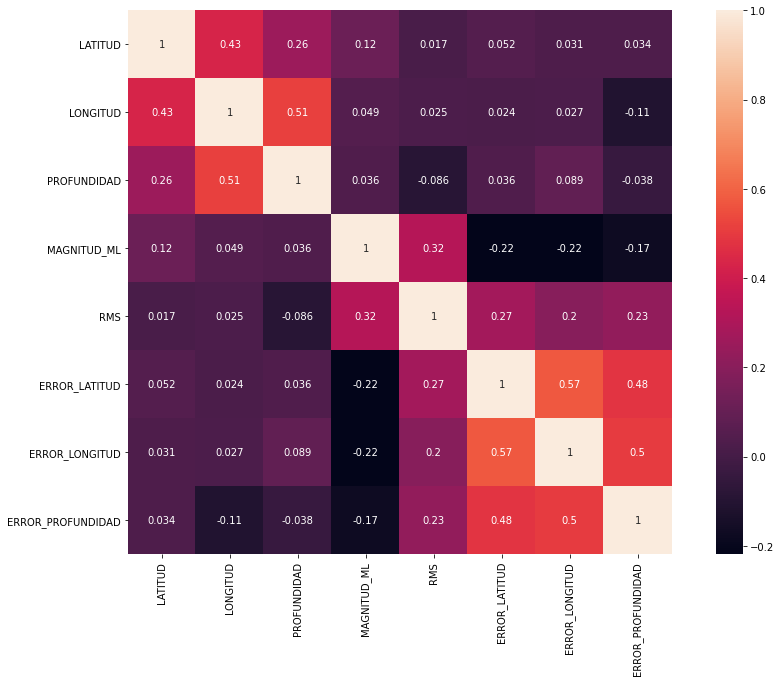

In [181]:
import seaborn as sns

plt.figure(figsize = (16,10))
sns.heatmap(dataset_y.corr(), square=True, annot=True)

In [182]:
#Mirar cuantos datos de cada comumna estan vacios
print(dataset_x.isnull().sum())
print(dataset_y.isnull().sum())

DIA     0
MES     0
HORA    0
dtype: int64
LATITUD              0
LONGITUD             0
PROFUNDIDAD          0
MAGNITUD_ML          0
RMS                  0
ERROR_LATITUD        0
ERROR_LONGITUD       0
ERROR_PROFUNDIDAD    0
dtype: int64


In [183]:
#Probar la nulidad
print(np.prod(pd.notnull(dataset_x)))
print(np.prod(pd.notnull(dataset_y)))

DIA     1
MES     1
HORA    1
dtype: int64
LATITUD              1
LONGITUD             1
PROFUNDIDAD          1
MAGNITUD_ML          1
RMS                  1
ERROR_LATITUD        1
ERROR_LONGITUD       1
ERROR_PROFUNDIDAD    1
dtype: int64


In [184]:
print(dataset_x.dtypes)
print(dataset_y.dtypes)

DIA       int64
MES       int64
HORA    float64
dtype: object
LATITUD              float64
LONGITUD             float64
PROFUNDIDAD          float64
MAGNITUD_ML          float64
RMS                  float64
ERROR_LATITUD        float64
ERROR_LONGITUD       float64
ERROR_PROFUNDIDAD    float64
dtype: object


In [0]:
#datos["HORA"] = datos.HORA.astype(float)

**Procederemos a analizar el mejor regresor para nuestro problema**

Importaciones de metodos de regresion

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR

DT_reg = DecisionTreeRegressor()
RF_reg = RandomForestRegressor()

Partiendo el Dataset

In [186]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import numpy as np

x = np.array(dataset_x.values)
y = np.array(dataset_y.values)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

DT_reg.fit(x_train,y_train)
RF_reg.fit(x_train,y_train)

pred_DT = DT_reg.predict(x_test)
pred_RF = RF_reg.predict(x_test)

DT_error=np.mean(mean_absolute_error(y_test,pred_DT))
RF_error=np.mean(mean_absolute_error(y_test,pred_RF))

print("DT ERROR -> ",DT_error,"\n")
print("RF ERROR -> ",RF_error,"\n")

DT ERROR ->  9.280075847284605 

RF ERROR ->  8.159847414751386 



Se calculan el error **(MAE)** para cada estimador y se escoge el **RandomForestRegressor**

Se procede a realizar la función para predecir el sismo

In [0]:
def sismo(dia,mes,hora):
  
    tiempo = 3600*hora # en segundos

    pred = RF_reg.predict([[dia, mes, tiempo]])
    Latitud = pred[0,0]
    Longitud = pred[0,1]
    Profundidad = pred[0,2]
    Magnitud = pred[0,3]
  
    import geopandas as gp

    latitud=round(pred[0,0], 5)
    longitud=round(pred[0,1], 5)
    print("DATOS DEL SISMO PREDECIDO")
    print("Latitud: ",latitud)
    print("Longitud: ",longitud)
    print("Magnitud: ",round(Magnitud,4),"° en la escala de Richter")
    print("Profundidad: ",round(Profundidad,4)," metros")
    
    df = pd.DataFrame(
        {'Latitude': [latitud],
        'Longitude': [longitud]}) 
    gdf = gp.GeoDataFrame(
        df, geometry=gp.points_from_xy(df.Longitude, df.Latitude))
    
    # Trayendo el dataset del mapa
    world = gp.read_file('colombia.geo.json')
    
    
    # Pintando el mapa de colombia.
    ax = world.plot(
        color='white', edgecolor='black',figsize=(15, 10))

    # Pintando el punto.
    gdf.plot(ax=ax, color='red')

    plt.show()

**PRUEBA DE LA FUNCIÓN**

DATOS DEL SISMO PREDECIDO
Latitud:  6.49397
Longitud:  -75.48448
Magnitud:  1.936 ° en la escala de Richter
Profundidad:  56.602  metros


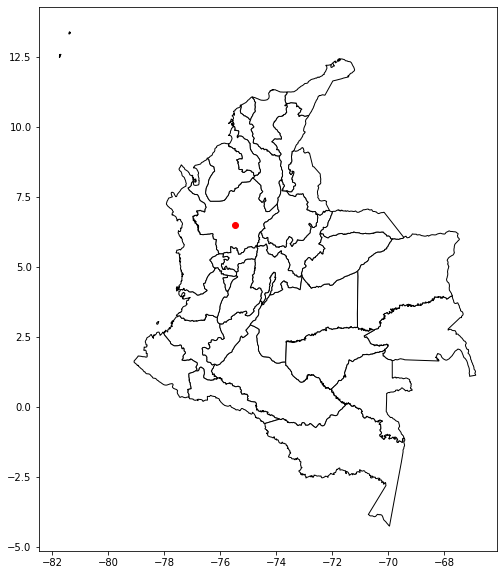

In [198]:
# sismo(dia,mes,hora)
# La hora en formato 24 Hrs

sismo(25,12,13)